# CSC 580
# Final Project
# Hithesh Shanmugam

In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\admin\appdata\local\temp\pip-req-build-75lo8lrw
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git 'C:\Users\admin\AppData\Local\Temp\pip-req-build-75lo8lrw'


# Import Necessary packages

In [ ]:
# from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

In [54]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils  import load_img
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [16]:
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

In [1]:
import os
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# Discriminator

In [3]:
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer : 4x4 kernel but Stride 1x1
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    #This slows down changes to the discriminator relative to the generator model during training.
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

# Resnet Block

In [4]:
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

# Generator

In [5]:
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

# Composite Model

In [6]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time. 
    g_model_1.trainable = True
    # mark discriminator and second generator as non-trainable
    d_model.trainable = False
    g_model_2.trainable = False
    
    # adversarial loss
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity loss
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # cycle loss - forward
    output_f = g_model_2(gen1_out)
    # cycle loss - backward
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    # define the optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

# Useful Functions

In [7]:
# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1. 
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0. 
def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake images
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)
    plt.close()

# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images 
#rather than the ones produced by the latest generators.
#Original paper recommended keeping an image buffer that stores 
#the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

# Training

In [18]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
    # define properties of the training run
    n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fake images
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples from each domain (A and B)
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples using both B to A and A to B generators.
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        # update generator B->A via the composite model
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        # update generator A->B via the composite model
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
        print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance periodically
        #If batch size (total images)=100, performance will be summarized after every 75th iteration.
        if (i+1) % (bat_per_epo * 5) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 10) == 0:
            # save the models
            # #If batch size (total images)=100, model will be saved after 
            #every 75th iteration x 5 = 375 iterations.
            save_models(i, g_model_AtoB, g_model_BtoA)

In [10]:
# load all images in a directory into memory
def load_images(path, size=(128,128)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    return asarray(data_list)

# Pre-Process dataset

Loaded dataA:  (765, 128, 128, 3)
Loaded dataB:  (765, 128, 128, 3)


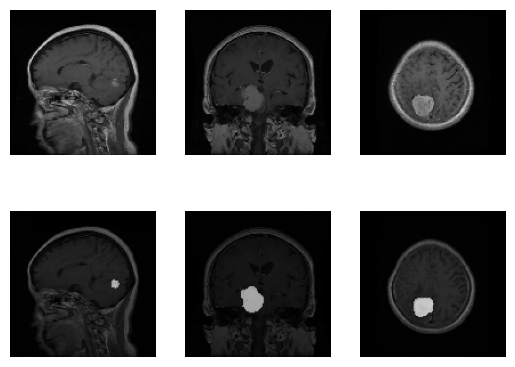

In [12]:
# dataset path
path = 'C:/Users/admin/Desktop/med-image/'

# load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=500,    
                 random_state=42) 

# load dataset B - Photos 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=500,    
                 random_state=42) 

# plot source images
n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()


In [13]:
# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

# Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
# And tanh ranges between -1 and 1
def preprocess_data(data):
    # load compressed arrays
    # unpack arrays
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

Loaded (500, 128, 128, 3) (500, 128, 128, 3)


In [14]:
# Preprocess the data
dataset = preprocess_data(data)

In [15]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

c:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
c:\Users\admin\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Begin training

In [19]:
from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=10)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 0s 483ms/step
Iteration>1, dA[1.810,1.189] dB[2.094,0.634] g[25.105,25.687]
1/1 [==============================] - 0s 19ms/step
Iteration>2, dA[2.018,1.351] dB[4.955,0.790] g[21.739,21.321]
1/1 [==============================] - 0s 19ms/step
Iteration>3, dA[1.535,1.594] dB[3.096,0.649] g[22.574,22.674]
1/1 [==============================] - 0s 18ms/step
Iteration>4, dA[2.803,1.410] dB[1.425,1.141] g[22.818,25.015]
1/1 [==============================] - 0s 19ms/step
Iteration>5, dA[4.489,1.221] dB[1.537,1.471] g[22.851,24.783]
1/1 [==============================] - 0s 19ms/step
Iteration>6, dA[0.893,2.400] dB[1.035,0.949] g[19.738,22.207]
1/1 [==============================] - 0s 20ms/step
Iteration>7, dA[4.274,4.240] dB[1.642,0.798] g[19.405,21.944]
1/1 [==============================] - 0s 20ms/step
Iteration>8, dA[1.400,2.892] dB[1.568,1.082] g[21.425,20.540]
1/1 [==============================] - 0s 19ms/step
Iteration>9, dA[2.278,1.308] dB[1.4

In [38]:
!pip install scikit-image

  Using cached scikit_image-0.20.0-cp39-cp39-win_amd64.whl (23.9 MB)
  Using cached imageio-2.26.0-py3-none-any.whl (3.4 MB)
  Using cached lazy_loader-0.1-py3-none-any.whl (8.6 kB)
  Using cached PyWavelets-1.4.1-cp39-cp39-win_amd64.whl (4.2 MB)


# Performance Measure

# Epoch 60 model AtoB

6/6 [==============================] - 2s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


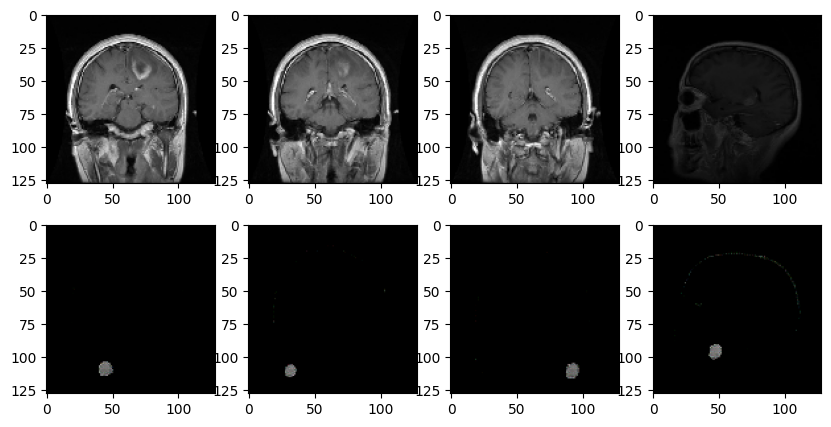

MSE: 0.8512
PSNR: 0.6995


In [53]:
# Load the saved model
model_path = "C:/Users/admin/Downloads/g_model_AtoB_030000.h5"
model = load_model(model_path)

# Define the path to the test file
test_file = "C:/Users/admin/Desktop/med-image/testA/"

# Define the input shape of the model
input_shape = (128, 128)

# Define the batch size
batch_size = 16

# Load and preprocess the images
image_list = []
for filename in os.listdir(test_file):
    img_path = os.path.join(test_file, filename)
    img = load_img(img_path, target_size=input_shape)
    img = img_to_array(img) / 255.0
    image_list.append(img)

# Resize the images to the input shape of the model
image_array = np.array(image_list, dtype=np.float32)
resized_images = tf.image.resize(image_array, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

# Evaluate the model on the images
predicted_images = model.predict(resized_images, batch_size=batch_size)

# Calculate MSE
mse = mean_squared_error(resized_images.numpy(), predicted_images)

# Calculate PSNR
psnr = peak_signal_noise_ratio(resized_images.numpy(), predicted_images, data_range=1.0)

# Plot the images
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i in range(4):
    ax[0][i].imshow(resized_images[i])
    ax[1][i].imshow(predicted_images[i])
plt.show()

# Print the results
print("MSE: {:.4f}".format(mse))
print("PSNR: {:.4f}".format(psnr))


# Epoch 20 model AtoB

6/6 [==============================] - 1s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


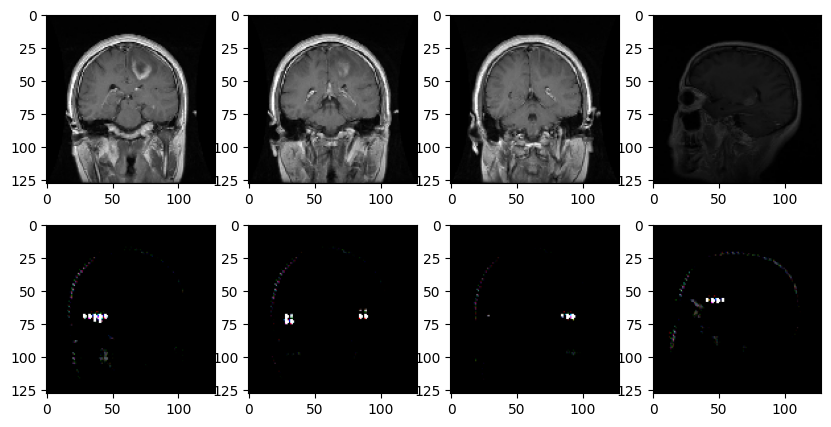

MSE: 0.8670
PSNR: 0.6200


In [55]:
# Load the saved model
model_path = "C:/Users/admin/Downloads/g_model_AtoB_010000.h5"
model = load_model(model_path)

# Define the path to the test file
test_file = "C:/Users/admin/Desktop/med-image/testA/"

# Define the input shape of the model
input_shape = (128, 128)

# Define the batch size
batch_size = 16

# Load and preprocess the images
image_list = []
for filename in os.listdir(test_file):
    img_path = os.path.join(test_file, filename)
    img = load_img(img_path, target_size=input_shape)
    img = img_to_array(img) / 255.0
    image_list.append(img)

# Resize the images to the input shape of the model
image_array = np.array(image_list, dtype=np.float32)
resized_images = tf.image.resize(image_array, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

# Evaluate the model on the images
predicted_images = model.predict(resized_images, batch_size=batch_size)

# Calculate MSE
mse = mean_squared_error(resized_images.numpy(), predicted_images)

# Calculate PSNR
psnr = peak_signal_noise_ratio(resized_images.numpy(), predicted_images, data_range=1.0)

# Plot the images
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i in range(4):
    ax[0][i].imshow(resized_images[i])
    ax[1][i].imshow(predicted_images[i])
plt.show()

# Print the results
print("MSE: {:.4f}".format(mse))
print("PSNR: {:.4f}".format(psnr))


# Epoch 60 model BtoA

6/6 [==============================] - 1s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


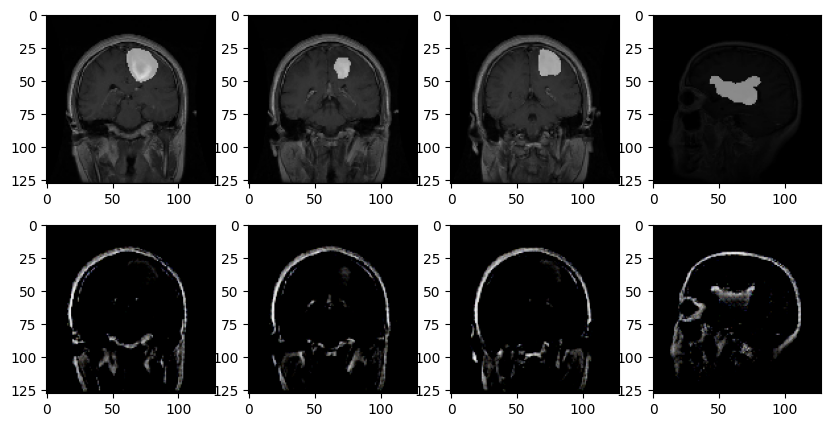

MSE: 0.6137
PSNR: 2.1205


In [56]:
# Load the saved model
model_path = "C:/Users/admin/Downloads/g_model_BtoA_030000.h5"
model = load_model(model_path)

# Define the path to the test file
test_file = "C:/Users/admin/Desktop/med-image/testB/"

# Define the input shape of the model
input_shape = (128, 128)

# Define the batch size
batch_size = 16

# Load and preprocess the images
image_list = []
for filename in os.listdir(test_file):
    img_path = os.path.join(test_file, filename)
    img = load_img(img_path, target_size=input_shape)
    img = img_to_array(img) / 255.0
    image_list.append(img)

# Resize the images to the input shape of the model
image_array = np.array(image_list, dtype=np.float32)
resized_images = tf.image.resize(image_array, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

# Evaluate the model on the images
predicted_images = model.predict(resized_images, batch_size=batch_size)

# Calculate MSE
mse = mean_squared_error(resized_images.numpy(), predicted_images)

# Calculate PSNR
psnr = peak_signal_noise_ratio(resized_images.numpy(), predicted_images, data_range=1.0)

# Plot the images
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i in range(4):
    ax[0][i].imshow(resized_images[i])
    ax[1][i].imshow(predicted_images[i])
plt.show()

# Print the results
print("MSE: {:.4f}".format(mse))
print("PSNR: {:.4f}".format(psnr))


# Epoch 20 model BtoA

6/6 [==============================] - 1s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


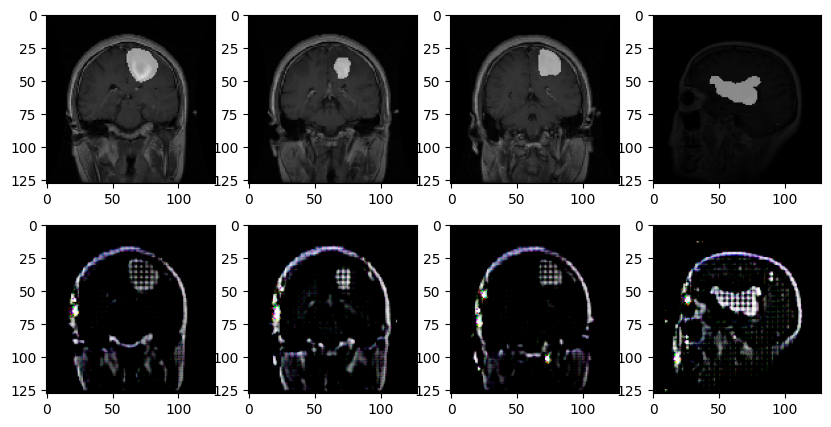

MSE: 0.5720
PSNR: 2.4259


In [57]:
# Load the saved model
model_path = "C:/Users/admin/Downloads/g_model_BtoA_010000.h5"
model = load_model(model_path)

# Define the path to the test file
test_file = "C:/Users/admin/Desktop/med-image/testB/"

# Define the input shape of the model
input_shape = (128, 128)

# Define the batch size
batch_size = 16

# Load and preprocess the images
image_list = []
for filename in os.listdir(test_file):
    img_path = os.path.join(test_file, filename)
    img = load_img(img_path, target_size=input_shape)
    img = img_to_array(img) / 255.0
    image_list.append(img)

# Resize the images to the input shape of the model
image_array = np.array(image_list, dtype=np.float32)
resized_images = tf.image.resize(image_array, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

# Evaluate the model on the images
predicted_images = model.predict(resized_images, batch_size=batch_size)

# Calculate MSE
mse = mean_squared_error(resized_images.numpy(), predicted_images)

# Calculate PSNR
psnr = peak_signal_noise_ratio(resized_images.numpy(), predicted_images, data_range=1.0)

# Plot the images
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for i in range(4):
    ax[0][i].imshow(resized_images[i])
    ax[1][i].imshow(predicted_images[i])
plt.show()

# Print the results
print("MSE: {:.4f}".format(mse))
print("PSNR: {:.4f}".format(psnr))
